<a href="https://colab.research.google.com/github/Traintain/2022-1-BI-Proyecto1-G4/blob/main/Proyecto_1_Grupo_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Inteligencia de negocios 2022-1**

**Proyecto 1 - Eligibilidad de un paciente para ensayos clínicos**

Juan Manuel Rivera López - 201534131

Juan Sebastián Arévalo - 201728738

Juan David Villamil – 201812268


# 0.Importacion de librerías

In [1]:
!pip install contractions --quiet
import nltk
nltk.download('all')

     |████████████████████████████████| 284 kB 31.6 MB/s 
     |████████████████████████████████| 106 kB 67.9 MB/s 
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_dat

True

In [2]:
#Manejo de datos
import pandas as pd
import numpy as np
import string

#Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re, string, unicodedata
import contractions
from contractions import contractions_dict
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

#Entrenamiento del modelo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

In [3]:
data_raw=pd.read_csv('clinical_trials_on_cancer_data_clasificacion.csv', sep=',', encoding = 'utf-8',index_col=None)

# 1.Entendimiento del negocio

Las intervenciones como ensayos clínicos en pacientes con cancer suelen ser muy restrictivos, ya que se excluye a pacientes con comorbilidades, tratamientos concomitantes o un límite de edad.

Para mejorar el proceso de selección de pacientes se realizó un clasificador binario, de forma que pueda predecir, a partir de un párrafo corto, si un paciente es candidato o no a ser parte de un ensayo clínico

# 2.Entendimiento de los datos

Daremos una revisión a la calidad de los datos

In [4]:
# Revisamos cuántos registros tenemos
data_raw.shape

(12000, 2)

In [5]:
# Luego vemos a grandes rasgos cada columna, para ver el tipo de dato que tiene
data_raw.head()

,label,study_and_condition
0,__label__0,study interventions are Saracatinib . recurren...
1,__label__1,study interventions are Stem cell transplantat...
2,__label__0,study interventions are Lenograstim . recurren...
3,__label__0,study interventions are Doxorubicin . stage ii...
4,__label__1,study interventions are Poly I-C . prostate ca...


A partir del diccionario sabemos que hay dos columnas

- **label:** indica si el paciente es elegible (0) o no elegible (1) para los ensayos clínicos
- **study_and_condition:** indica información sobre el estudio y sobre el tipo de cáncer del paciente. Estos datos están separados por un punto

Teniendo esto en cuenta convertiremos los valores de label a valor numérico y separaremos los valores de study y condition en dos columnas aparte

In [6]:
def cleanAndSeparate(data):
  
  # Seleccionamos el último valor de la columna label. Con esto sabremos si es clase 0 o 1
  data['label'] = pd.to_numeric(data['label'].apply(lambda x: x[-1]))
  

  # Copiamos las columnas a separar en un dataframe independiente
  temp=data['study_and_condition'].str.split('.',expand=True,n=1)

  # Unimos los datos de los estudios, eliminando el encabezado
  data['study'] = temp[0].apply(lambda x: x[24:])
  data['condition']=temp[1]
  data.drop(labels='study_and_condition',axis=1,inplace=True)
  
  return data

In [7]:
data=data_raw.copy()
data=cleanAndSeparate(data)
data

,label,study,condition
0,0,Saracatinib,recurrent verrucous carcinoma of the larynx d...
1,1,Stem cell transplantation,hodgkin lymphoma diagnosis and history of con...
2,0,Lenograstim,recurrent adult diffuse mixed cell lymphoma d...
3,0,Doxorubicin,stage iii diffuse large cell lymphoma diagnos...
4,1,Poly I-C,prostate cancer diagnosis and unresolved irae...
...,...,...,...
11995,0,Prednisolone hemisuccinate,recurrent childhood large cell lymphoma diagn...
11996,0,Bevacizumab,recurrent rectal cancer diagnosis and absolut...
11997,1,"Antibodies, Monoclonal",recurrent lymphoblastic lymphoma diagnosis an...
11998,0,Vorinostat,colorectal cancer diagnosis and patients must...


## Calidad de los datos

### Validez

Cada columna tiene el tipo de dato que le corresponde según el diccionario. Revisaremos cada columna en caso de que haya alguno no válido

In [8]:
data.dtypes

label         int64
study        object
condition    object
dtype: object

In [9]:
columnas = data.columns
for name in columnas:
  print(name)
  print(data[name].unique())
  print()

label
[0 1]

study
['Saracatinib ' 'Stem cell transplantation ' 'Lenograstim ' ...
 'Estradiol 17 beta-cypionate ' 'Adalimumab '
 'PV-10 (rose bengal disodium, 10%) ']

condition
[' recurrent verrucous carcinoma of the larynx diagnosis and patients must agree to use adequate birth control for the duration of study participation and for at least eight weeks after discontinuation of study drug'
 ' hodgkin lymphoma diagnosis and history of congenital hematologic immunologic or metabolic disorder which in the estimation of the pi poses prohibitive risk to the recipient'
 ' recurrent adult diffuse mixed cell lymphoma diagnosis and creatinine clearance crcl greater than fifty ml per minute all tests must be performed within twenty-eight days prior to registration'
 ...
 ' recurrent lymphoblastic lymphoma diagnosis and and intrathecal intraventricular therapy'
 ' colorectal cancer diagnosis and patients must have received at least one prior chemotherapy regimen for advanced disease'
 ' ovaria

### Completitud

In [10]:
data.isna().sum()

label        0
study        0
condition    0
dtype: int64

### Presencia de duplicados
Se mirará si hay filas que sean idénticas

In [11]:
data.duplicated().value_counts()

False    11988
True        12
dtype: int64

In [12]:
# Dado que hay 12 filas repetidas, se eliminarán
data.drop_duplicates(inplace=True)

## Perfilamiento de los datos

Veamos si el número de pacientes en cada categoría está balanceado

In [13]:
# Revisamos el número de datos etiquetados como elegibles y como no elegibles
data['label'].value_counts()

1    5996
0    5992
Name: label, dtype: int64

Revisemos también cuántos tipos de estudio clínico tenemos

In [14]:
data['study'].value_counts()

Antibodies, Monoclonal                438
Albumin-Bound Paclitaxel              269
Paclitaxel                            269
Antibodies                            259
Bevacizumab                           239
                                     ... 
rF-PSA                                  1
iodinated contrast dye                  1
JCAR017 2-dose schedule                 1
E6201                                   1
PV-10 (rose bengal disodium, 10%)       1
Name: study, Length: 1660, dtype: int64

In [15]:
data['study'].value_counts().describe()

count    1660.000000
mean        7.221687
std        26.731496
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       438.000000
Name: study, dtype: float64

Se puede ver que el 75% de los tipos de estudio clínico tienen 1 o 2 entradas en la tabla. Teniendo en cuenta esto, se considera que esta columna no aporta mucha información al análisis, por lo que se eliminará

In [16]:
data.drop(labels='study',axis=1,inplace=True)

Para visualizar el contenido de las frases crearemos un mapa de palabras donde podamos ver las palabras más comunes en la categoría elegible y la categoría no elegible

In [17]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

def mostrar_grafico(palabras,stopwords=[]):
    comment_words = ''
    
    # iterate through the csv file
    for val in palabras:
        
        # typecaste each val to string
        val = str(val)
    
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
    
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
    
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

---------- Words for class: 0 ----------


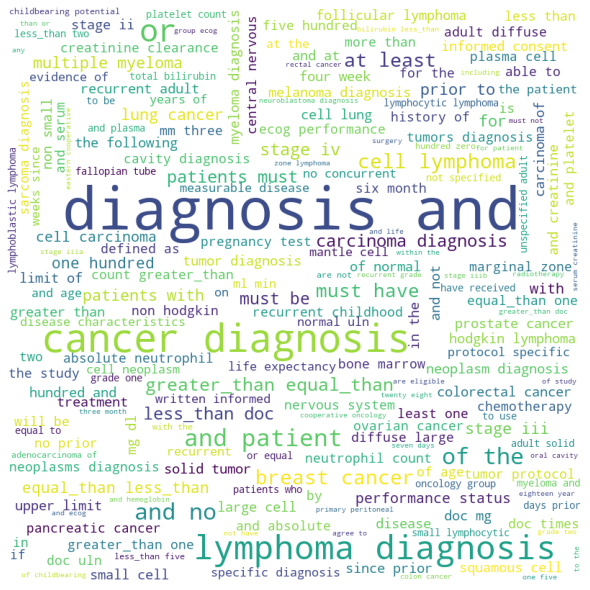

---------- Words for class: 1 ----------


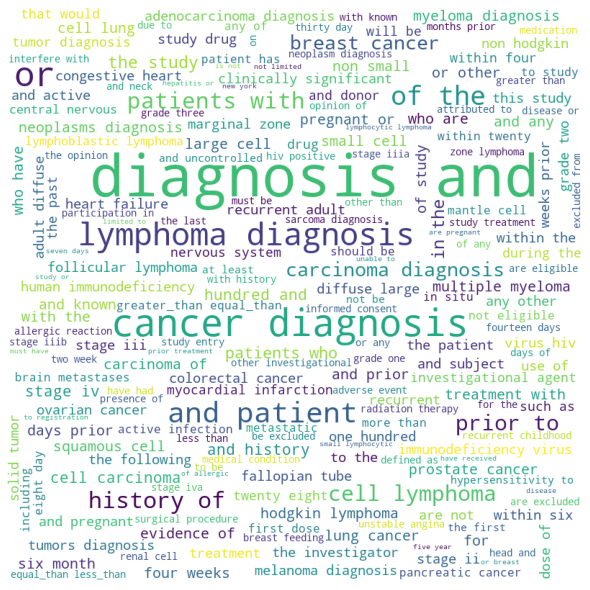

In [18]:
for i in range(2):
    print(f'---------- Words for class: {i} ----------')
    mostrar_grafico( data.loc[data['label']==i,'condition'])

---------- Words for class: 0 ----------


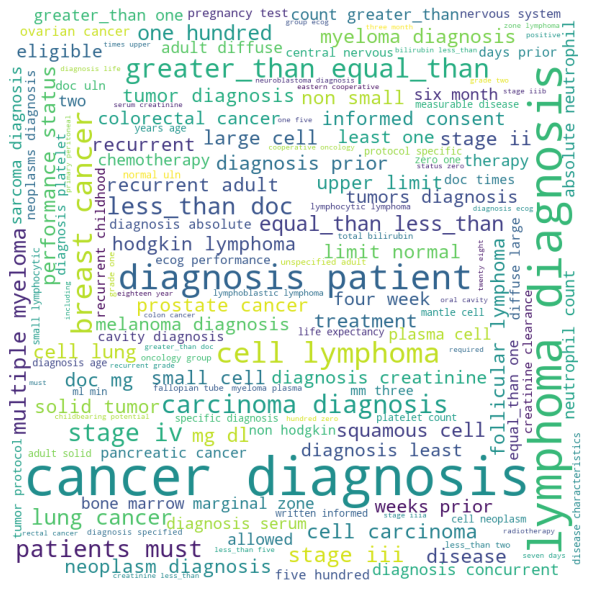

---------- Words for class: 1 ----------


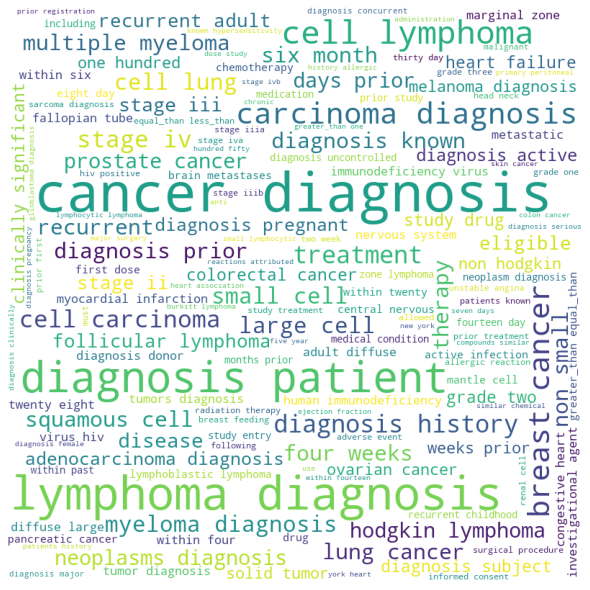

In [19]:
for i in range(2):
    print(f'---------- Words for class: {i} ----------')
    mostrar_grafico( data.loc[data['label']==i,'condition'],stopwords=STOPWORDS)

Podemos ver que las palabras que más se repiten en ambos conjuntos son muy similares entre sí

# 3.Preparación de los datos
Se preparán las funciones para procesar los textos, y se dividirá la base de datos en train y test

In [20]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [21]:
X_train, y_train = train['condition'], train['label']
X_test, y_test = test['condition'], test['label']
X_train

288       stage ii pancreatic cancer diagnosis and crea...
2622      recurrent grade three follicular lymphoma dia...
6455      stage iii adult hodgkin lymphoma diagnosis an...
3673      extensive stage small cell lung cancer diagno...
7950                            lymphoma diagnosis and age
                               ...                        
11976     contiguous stage ii adult immunoblastic large...
5194      breast cancer diagnosis and repeated core nee...
5393              metastatic prostate cancer diagnosis and
860       stage iv squamous cell carcinoma of the paran...
7273      lung cancer diagnosis and absolute neutrophil...
Name: condition, Length: 9590, dtype: object

## 3.1 Eliminación del ruido
En esta fase se busca normalizar las palabras, de forma que dos palabras que tengan pequeñas diferencias entre sí no se consideren como distintas

### Expandir contracciones

Dado que las frases están en inglés, lo primero que se hará es expandir las contracciones, para que por ejemplo no tome that's y that is como dos palabras distintas

In [22]:
new_X_train= X_train.apply(contractions.fix) #Aplica la corrección de las contracciones
new_X_train

288       stage ii pancreatic cancer diagnosis and crea...
2622      recurrent grade three follicular lymphoma dia...
6455      stage iii adult hodgkin lymphoma diagnosis an...
3673      extensive stage small cell lung cancer diagno...
7950                            lymphoma diagnosis and age
                               ...                        
11976     contiguous stage ii adult immunoblastic large...
5194      breast cancer diagnosis and repeated core nee...
5393              metastatic prostate cancer diagnosis and
860       stage iv squamous cell carcinoma of the paran...
7273      lung cancer diagnosis and absolute neutrophil...
Name: condition, Length: 9590, dtype: object

### Llevar todo a minúsculas

Para evitar que tome dos palabras iguales como diferentes se llevará a minúscula todas las letras

In [23]:
def to_lowercase(phrase):
    new_phrase = []
    for word in phrase:
        new_word = word.lower()
        new_phrase.append(new_word)
    return "".join(new_phrase)

In [24]:
new_X_train=new_X_train.apply(to_lowercase)
new_X_train

288       stage ii pancreatic cancer diagnosis and crea...
2622      recurrent grade three follicular lymphoma dia...
6455      stage iii adult hodgkin lymphoma diagnosis an...
3673      extensive stage small cell lung cancer diagno...
7950                            lymphoma diagnosis and age
                               ...                        
11976     contiguous stage ii adult immunoblastic large...
5194      breast cancer diagnosis and repeated core nee...
5393              metastatic prostate cancer diagnosis and
860       stage iv squamous cell carcinoma of the paran...
7273      lung cancer diagnosis and absolute neutrophil...
Name: condition, Length: 9590, dtype: object

### Extraer información de la etapa

Al ser contexto de pacientes oncológicos, la etapa en que se encuentra el cáncer es un factor importante. Por esto, se unirá la palabra stage con la siguiente palabra cuando esta sea un número romano

In [25]:
etapasCancer= {"stage 0":"stage0","stage i":"stage1", "stage ii":"stage2", "stage iii":"stage3", "stage iv":"stage4"}

In [26]:
def get_stages(phrase):
    words=phrase.split(" ")
    new_phrase = []
    prev_word=False

    for word in words:
      
      # Caso donde la palabra anterior es "stage"
      if prev_word:
        stage = "stage"+" "+word
        etapa=etapasCancer.get(stage)
        if etapa != None:
          # Si efectivamente es una etapa, añado esto a la palabra
          new_phrase.append(etapa+" ")
        prev_word=False
      else:
        if word != "stage":
          new_phrase.append(word)
          new_phrase.append(" ")
        else:
          prev_word=True
    return "".join(new_phrase)[:-1]

In [27]:
new_X_train=new_X_train.apply(get_stages)
new_X_train

288       stage2 pancreatic cancer diagnosis and creati...
2622      recurrent grade three follicular lymphoma dia...
6455      stage3 adult hodgkin lymphoma diagnosis and s...
3673      extensive cell lung cancer diagnosis and reco...
7950                            lymphoma diagnosis and age
                               ...                        
11976     contiguous stage2 adult immunoblastic large c...
5194      breast cancer diagnosis and repeated core nee...
5393              metastatic prostate cancer diagnosis and
860       stage4 squamous cell carcinoma of the paranas...
7273      lung cancer diagnosis and absolute neutrophil...
Name: condition, Length: 9590, dtype: object

### Eliminar signos de puntuación

In [28]:
def remove_punctuation(phrase):
    return phrase.translate(str.maketrans('','',string.punctuation))

In [29]:
new_X_train=new_X_train.apply(remove_punctuation)
new_X_train

288       stage2 pancreatic cancer diagnosis and creati...
2622      recurrent grade three follicular lymphoma dia...
6455      stage3 adult hodgkin lymphoma diagnosis and s...
3673      extensive cell lung cancer diagnosis and reco...
7950                            lymphoma diagnosis and age
                               ...                        
11976     contiguous stage2 adult immunoblastic large c...
5194      breast cancer diagnosis and repeated core nee...
5393              metastatic prostate cancer diagnosis and
860       stage4 squamous cell carcinoma of the paranas...
7273      lung cancer diagnosis and absolute neutrophil...
Name: condition, Length: 9590, dtype: object

### Eliminar stopwords
Se retirarán conectores lógicos de las frases

In [30]:
def remove_stopwords(phrase, stopwords=stopwords.words('english')):
    words=phrase.split(" ")
    new_phrase = []
    for word in words:
        if word not in stopwords:
            new_phrase.append(word)
            new_phrase.append(" ")
    return "".join(new_phrase)[:-1]

In [31]:
new_X_train=new_X_train.apply(remove_stopwords)
new_X_train

288       stage2 pancreatic cancer diagnosis creatinine...
2622      recurrent grade three follicular lymphoma dia...
6455      stage3 adult hodgkin lymphoma diagnosis subje...
3673      extensive cell lung cancer diagnosis recovere...
7950                                lymphoma diagnosis age
                               ...                        
11976     contiguous stage2 adult immunoblastic large c...
5194      breast cancer diagnosis repeated core needle ...
5393                  metastatic prostate cancer diagnosis
860       stage4 squamous cell carcinoma paranasal sinu...
7273      lung cancer diagnosis absolute neutrophil cou...
Name: condition, Length: 9590, dtype: object

## 3.2 Tokenización
En esta fase se dividen las frases en palabras, donde cada palabra será un token

In [32]:
new_X_train = new_X_train.apply(word_tokenize)
new_X_train.head()

288     [stage2, pancreatic, cancer, diagnosis, creati...
2622    [recurrent, grade, three, follicular, lymphoma...
6455    [stage3, adult, hodgkin, lymphoma, diagnosis, ...
3673    [extensive, cell, lung, cancer, diagnosis, rec...
7950                           [lymphoma, diagnosis, age]
Name: condition, dtype: object

## 3.3 Normalización

In [33]:
# Funciones tomadas de https://www.kdnuggets.com/2018/03/text-data-preprocessing-walkthrough-python.html

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    words = lemmatize_verbs(words)
    words = stem_words(words)
    return words

In [34]:
new_X_train = new_X_train.apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
new_X_train.head()

288     [stage2, pancr, cant, diagnos, creatinin, gre,...
2622    [recur, grad, three, follicul, lymphom, diagno...
6455    [stage3, adult, hodgkin, lymphom, diagnos, sub...
3673    [extend, cel, lung, cant, diagnos, recov, pri,...
7950                               [lymphom, diagnos, ag]
Name: condition, dtype: object

In [35]:
# Se guardan los textos procesados en la variable X_trian
X_train = new_X_train.apply(lambda x: ' '.join(map(str, x)))
X_train.head

<bound method NDFrame.head of 288      stage2 pancr cant diagnos creatinin gre doc mg dl
2622     recur grad three follicul lymphom diagnos pri ...
6455     stage3 adult hodgkin lymphom diagnos subject r...
3673        extend cel lung cant diagnos recov pri therapy
7950                                    lymphom diagnos ag
                               ...                        
11976    contigu stage2 adult immunoblast larg cel lymp...
5194       breast cant diagnos rep cor needl biopsy permit
5393                             metast prost cant diagnos
860      stage4 squam cel carcinom paranas sin nas cav ...
7273     lung cant diagnos absolv neutrophil count ant ...
Name: condition, Length: 9590, dtype: object>

## 3.4 Transformación en matriz de frecuencias
Se mirará la aparición de palabras dentro de cada texto. Para esto se tienen varias opciones: ver si la palabra está o no en el texto (tranformación binaria), ver el número de ocurrencias en cada frase (tranformación por frecuencia) o usando la transofrmación inversa de la frecuencia, donde se analiza la aparición de una palabra en un texto vs que tan frecuente es en todos los textos

In [36]:
# Se transforma el texto con una transformación binaria 1 a 1.
dummy = CountVectorizer(binary=True, lowercase = False)
X_dummy = dummy.fit_transform(X_train)
print(X_dummy.shape)

(9590, 4643)


In [37]:
# También, se puede realizar el conteo de las palabras presentes.
count = CountVectorizer()
X_count = count.fit_transform(X_train)
print(X_count.shape)

(9590, 4643)


In [38]:
#Se puede realizar la transformación Term-frecuency times inverse Document-frecuency.
tf_idf = TfidfVectorizer()
X_tf_idf = tf_idf.fit_transform(X_train)
print(X_tf_idf.shape)

(9590, 4643)


# 4.Modelado

In [39]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,size=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')



    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Árbol de decisión